In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_excel('./excels/SPY.xlsx')
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)
df['returns'] = df['Close'].pct_change()

# Parameters
lookback = 20
long_entry_threshold = -0.5  # zscore threshold for going long
short_entry_threshold = 0.5  # zscore threshold for going short

# Calculate rolling mean, std dev, and zscore for returns
df['roll_mean'] = df['returns'].rolling(window=lookback).mean()
df['roll_std'] = df['returns'].rolling(window=lookback).std()
df['zscore'] = (df['returns'] - df['roll_mean']) / df['roll_std']

# Generate discrete long and short entry signals
df['long_entry'] = 0
df['short_entry'] = 0
df.loc[df['zscore'] < long_entry_threshold, 'long_entry'] = 1      # Long entry signal (+1)
df.loc[df['zscore'] > short_entry_threshold, 'short_entry'] = 1    # Short entry signal (+1)

# Generate exit signals that clear positions
df['long_exit'] = 0
df['short_exit'] = 0
df.loc[df['zscore'] > 0, 'long_exit'] = 1     # Clear all longs when zscore >= 0
df.loc[df['zscore'] < 0, 'short_exit'] = 1    # Clear all shorts when zscore <= 0

df['long_pos'] = 0
df['short_pos'] = 0

# To propagate the reset effect forward in time for longs:
for i in range(1, len(df)):
    if df['long_exit'].iloc[i] == 1:
        df.at[df.index[i], 'long_pos'] = 0
    else:
        # If no exit today, position is previous day's position plus today's entry
        if i > 0:
            df.at[df.index[i], 'long_pos'] = df.at[df.index[i-1], 'long_pos'] + df['long_entry'].iloc[i]

# Propagate the reset effect forward in time for shorts:
for i in range(1, len(df)):
    if df['short_exit'].iloc[i] == 1:
        df.at[df.index[i], 'short_pos'] = 0
    else:
        if i > 0:
            df.at[df.index[i], 'short_pos'] = df.at[df.index[i-1], 'short_pos'] + df['short_entry'].iloc[i]

# Net position = long positions - short positions
df['net_position'] = df['long_pos'] - df['short_pos']

# Lag position by one day to avoid lookahead bias
df['net_position_lagged'] = df['net_position'].shift()

# Calculate strategy daily returns
df['strategy_return'] = df['net_position_lagged'] * df['returns']

# Sharpe ratio
annual_factor = np.sqrt(252)
sharpe = annual_factor * df['strategy_return'].mean() / df['strategy_return'].std()
print("Sharpe Ratio:", sharpe)

# Check the signals and positions
print(df[['long_entry', 'short_entry', 'long_exit', 'short_exit',
          'long_pos', 'short_pos', 'net_position', 'net_position_lagged', 'strategy_return']].tail(10))

plt.plot(df['strategy_return'].cumsum())
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './excels/SPY.xlsx'

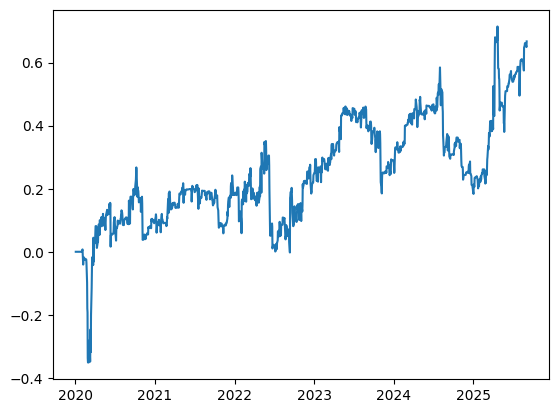

maxDD: -0.3559650950317693
maxDDD: 393.0
Start of DD: 39


In [11]:
from _03_drawdowns import calculateMaxDD

cumret = np.cumprod(1 + df['strategy_return']) - 1
plt.plot(cumret)
plt.show()
maxDD, maxDDD, startDDDay = calculateMaxDD(cumret.values)
print("maxDD:", maxDD)
print("maxDDD:", maxDDD)
print("Start of DD:", startDDDay)
